In [85]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import pandas as pd
from collections import *
import seaborn as sns
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from sklearn.metrics import fbeta_score, precision_score, make_scorer, average_precision_score
import warnings
from scipy.misc import imrotate
import skimage.io as sio
from scipy.io import loadmat
import math
from pdb import set_trace as t
from glob import glob
from skimage import feature
from scipy import ndimage

In [86]:
# Check for SIFT and SURF. If this fails, SIFT/SURF will not run
sift = cv2.xfeatures2d.SIFT_create()
print type(sift)
print 'CV2 Loaded, Version: ' + cv2.__version__

<type 'cv2.xfeatures2d_SIFT'>
CV2 Loaded, Version: 3.2.0-dev


In [87]:
df = pd.read_csv('../data/train.csv')
image_paths = sorted(glob('../data/train-jpg/*.jpg'))
image_names = list(map(lambda row: row.split("/")[-1][:-4], image_paths))

In [88]:
def run_sift(directory, filename):
    gray_img = cv2.imread(directory + filename, 0)
    color_img = cv2.imread(directory + filename)
    sift = cv2.xfeatures2d.SIFT_create()
    kp, desc = sift.detectAndCompute(gray_img, None)
    return kp, desc

In [117]:
def sift_test(directory, filename):
    kp, desc = run_sift(directory, filename)
    color_img = cv2.imread(directory + filename)
    gray_img = cv2.imread(directory + filename, 0)
    plt.imshow(cv2.drawKeypoints(gray_img, kp, color_img.copy()))
    #print kp, desc

In [118]:
Hthresh = 100
nOctaves = 4
nOctaveLayers = 3
extended = False
upright = True
def run_surf(directory, filename):
    gray_img = cv2.imread(directory + filename, 0)
    color_img = cv2.imread(directory + filename)
    surf = cv2.xfeatures2d.SURF_create(Hthresh, nOctaves, nOctaveLayers, extended, upright)
    kp, desc = surf.detectAndCompute(gray_img, None)
    return kp, desc

def surf_test(directory, filename):
    kp, desc = run_surf(directory, filename)
    color_img = cv2.imread(directory + filename)
    gray_img = cv2.imread(directory + filename, 0)
    plt.imshow(cv2.drawKeypoints(gray_img, kp, color_img.copy()))
    #print kp, desc

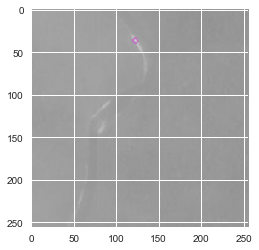

In [119]:
sift_test('../data/train-jpg/', 'train_5.jpg')

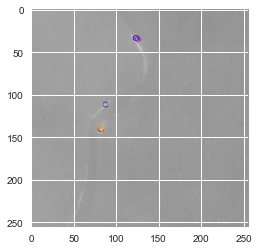

In [120]:
surf_test('../data/train-jpg/', 'train_5.jpg')

In [108]:
def sift_files(directory, count_break):
    count = 0
    sift_kp = []
    sift_desc = []
    sift_images = []
    for filename in os.listdir(directory):
        if count == count_break:
            break
        if filename.endswith(".jpg"):
            kp, desc = run_sift(directory, filename)
            if desc is not None:
                sift_kp.append(kp)
                sift_desc.append(desc)
                sift_images.append(filename)
                count += 1
    print len(sift_kp), len(sift_desc), len(sift_images)
    return sift_kp, sift_desc, sift_images

In [109]:
def surf_files(directory, count_break):
    count = 0
    surf_kp = []
    surf_desc = []
    surf_images = []
    for filename in os.listdir(directory):
        if count == count_break:
            break
        if filename.endswith(".jpg"):
            kp, desc = run_surf(directory, filename)
            if desc is not None:
                surf_kp.append(kp)
                surf_desc.append(desc)
                surf_images.append(filename)
                count += 1
    print len(surf_kp), len(surf_desc), len(surf_images)
    return surf_kp, surf_desc, surf_images

In [112]:
sift_kp, sift_desc, sift_images = sift_files('../data/train-jpg/', 1000)

1000 1000 1000


In [113]:
surf_kp, surf_desc, surf_images = surf_files('../data/train-jpg/', 1000)

1000 1000 1000


In [127]:
# TODO: F2 requires true positives (tp), false positives (fp), 
# and false negatives (fn)
def F2_score(tp, fp, fn):
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    beta = 2
    F2_score = (1 + beta**2)*precision*recall/(beta**2*precision+recall)
    return F2_score